# 0.0 IMPORTS

In [1]:
import psycopg2 as pg
import pandas.io.sql as psql
from IPython.display import Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
import pickle
import json

from flask import Flask, request, Response
# from health_insurance import HealthInsurance

from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import linear_model as lm
from sklearn import neighbors as nh
from sklearn import linear_model as lm

## 0.2 Load Data

In [2]:
# Credentials

# host = 'url-base-aws'
# port = port
# database = 'comunidadedsdb'
# user = '***'
# pwd = '***'

In [3]:
# conn = pg.connect(user=user, 
#                   password=pwd, 
#                   host=host, 
#                   port=port, 
#                   database=database)

In [4]:
# query_vehicle = """
#     SELECT * 
#     FROM pa004.vehicle v
# """

# query_insurance = """
#     SELECT * 
#     FROM pa004.insurance i
# """

# query_users = """
#     SELECT * 
#     FROM pa004.users u
# """

# df_vehicle = psql.read_sql(query_vehicle, conn)
# df_insurance = psql.read_sql(query_insurance, conn)
# df_users = psql.read_sql(query_users, conn)

# df_aux = pd.merge( df_users, df_insurance, how='left', on='id')
# df_raw = pd.merge( df_aux, df_vehicle, how='left', on='id')
# df_raw.to_csv('datasets/train_insurance.csv', index=False)

In [5]:
df_raw = pd.read_csv('../data/raw/db_raw.csv')
df_raw.head()

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,response,driving_license,vehicle_age,vehicle_damage
0,1,Male,44,28.0,26.0,0,40454.0,217,1,1,> 2 Years,Yes
1,2,Male,76,3.0,26.0,0,33536.0,183,0,1,1-2 Year,No
2,3,Male,47,28.0,26.0,0,38294.0,27,1,1,> 2 Years,Yes
3,4,Male,21,11.0,152.0,1,28619.0,203,0,1,< 1 Year,No
4,5,Female,29,41.0,152.0,1,27496.0,39,0,1,< 1 Year,No


# 1.0 DATA DESCRIPTIONS

In [6]:
df1 = df_raw.copy()

## 1.1 DATA DIMENSIONS

In [7]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 381109
Number of columns: 12


## 1.2 DATA TYPES

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   gender                381109 non-null  object 
 2   age                   381109 non-null  int64  
 3   region_code           381109 non-null  float64
 4   policy_sales_channel  381109 non-null  float64
 5   previously_insured    381109 non-null  int64  
 6   annual_premium        381109 non-null  float64
 7   vintage               381109 non-null  int64  
 8   response              381109 non-null  int64  
 9   driving_license       381109 non-null  int64  
 10  vehicle_age           381109 non-null  object 
 11  vehicle_damage        381109 non-null  object 
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


## 1.3 CHECK TYPES

In [9]:
df1['vehicle_damage'] = df1['vehicle_damage'].apply( lambda x: 1 if x=='Yes' else 0)

## 1.4 CHECK NA

In [10]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
previously_insured      0
annual_premium          0
vintage                 0
response                0
driving_license         0
vehicle_age             0
vehicle_damage          0
dtype: int64

## 1.5 DESCRIPTIVE STATISTICS

### 1.5.1 Numerical Attributes

In [11]:
num_attr = df1.select_dtypes(include=['int64', 'float64'])
cat_attr = df1.select_dtypes(exclude=['int64', 'float64'])

In [12]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame( num_attr.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attr.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attr.apply( np.std ) ).T
d2 = pd.DataFrame( num_attr.apply( min ) ).T
d3 = pd.DataFrame( num_attr.apply( max ) ).T
d4 = pd.DataFrame( num_attr.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attr.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attr.apply( lambda x: x.kurtosis() ) ).T

# Concat
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
3,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
7,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788
8,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
9,vehicle_damage,0.0,1.0,1.0,0.504877,1.0,0.499976,-1.950724e-02,-1.999630


### 1.5.2 Categorical Attributes

<AxesSubplot: xlabel='vehicle_age', ylabel='response'>

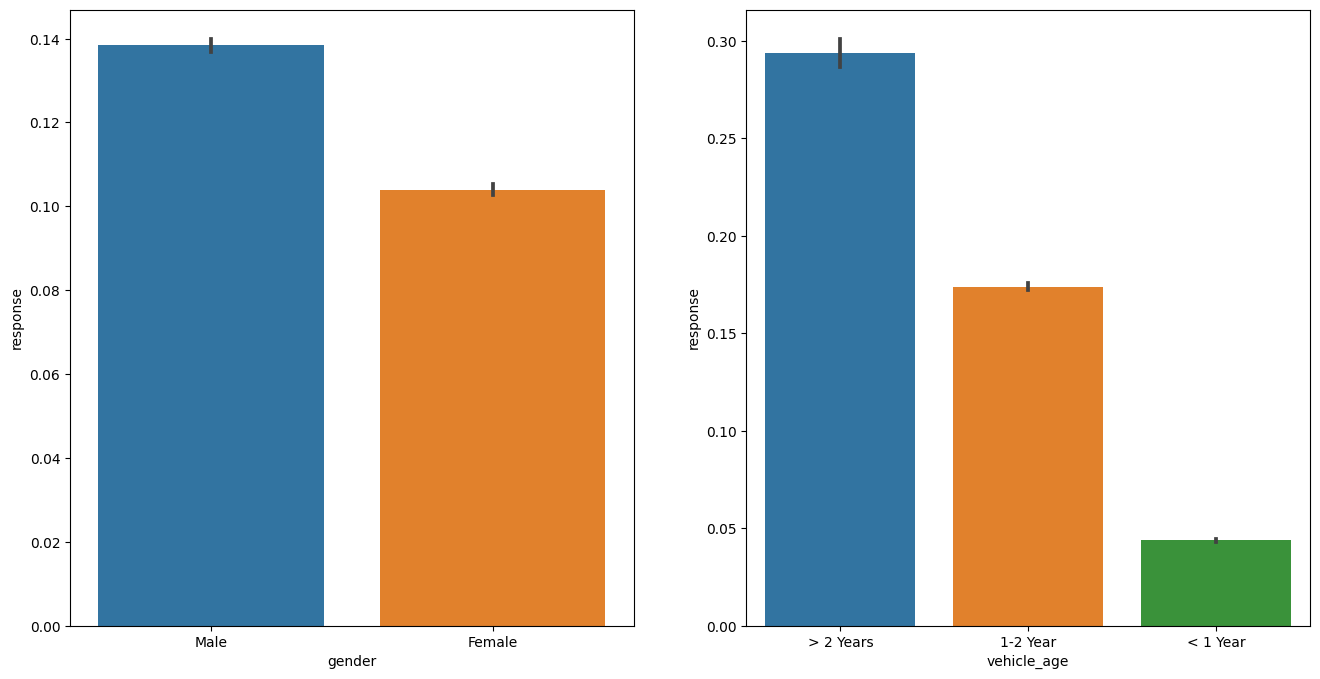

In [13]:
plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
sns.barplot(x='gender', y='response', data=df1)

plt.subplot(1, 2, 2)
sns.barplot(x='vehicle_age', y='response', data=df1)

# 2.0 FEATURE ENGINEERING

In [14]:
df2 = df1.copy()

## 2.1 Feature Engineering

In [15]:
df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_2_years' if x=='> 2 Years' else
                                                         'between_1_2_year' if x=='1-2 Year' else 'below_1_year')

## 2.2 Mind Map Hypothesis

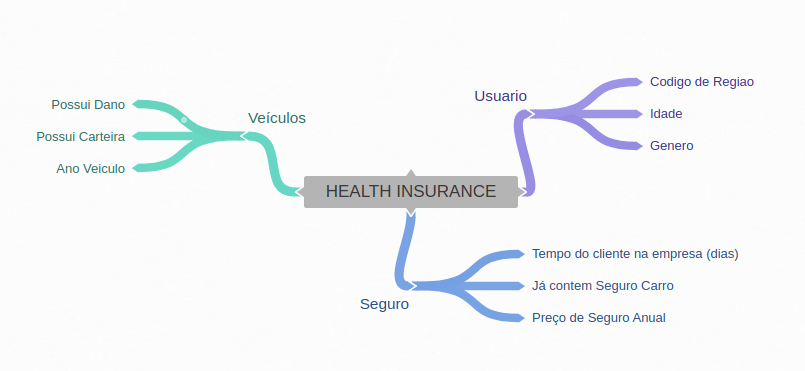

In [16]:
Image('../reports/figures/mind-map-pa004.png')

## 2.3 Creation of Hypotheses

### 2.3.1 Users

**1.** Usuarios acima de 40 anos devem aceitar mais o seguro de carro.

**2.** Usuarias mulheres devem aceitar mais o seguro de carro.

**3.** Usuarios que mais aceitam o seguro de carro estão concentrados em determinados códigos da região

### 2.3.2 Vehicles

**1.** Veículos que já tiveram algum dano normalmente não contratam seguro de carro.

**2.** Veículos em que o proprietario não possui carteira não contratam seguro de carro.

**3.** Veículos com mais de 2 anos contratam seguro de carro.

### 2.3.3 Insurance

**1.** Usuarios com contrato em menos de 6 meses em outro produto não contratam seguro de carro

**2.** Quem contém seguro de carro não contrata outro seguro.

**3.** Quem mais paga o premio anual contrata outro seguro

# 3.0 EXPLORATORY DATA ANALYSIS

In [17]:
df3 = df2.copy()

## 3.1 Univariate Analysis

### 3.1.1 - Age

<AxesSubplot: xlabel='response', ylabel='age'>

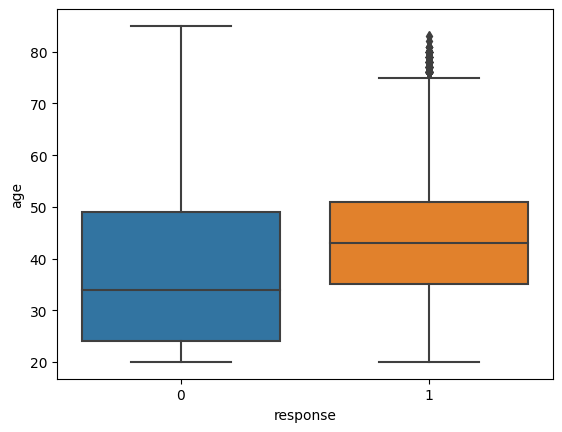

In [18]:
sns.boxplot(x='response', y='age', data=df3)

<AxesSubplot: xlabel='age', ylabel='Count'>

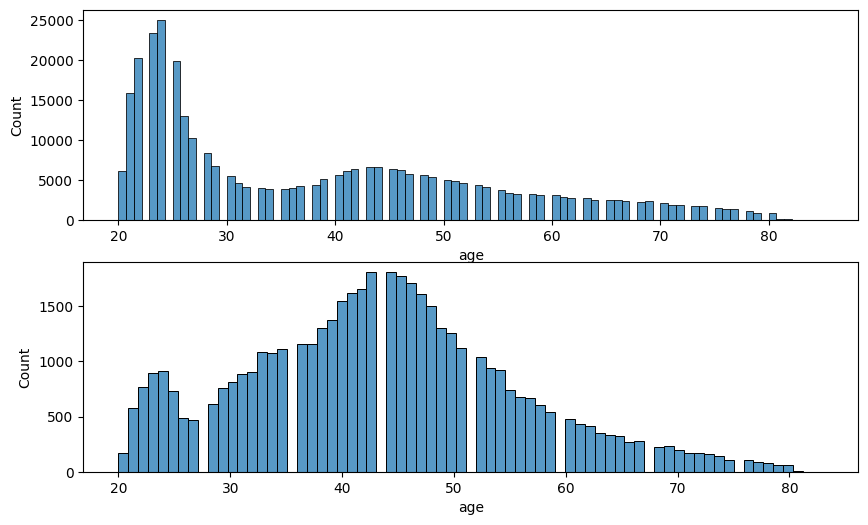

In [19]:
aux00 = df3.loc[df3['response'] == 0, 'age']
aux01 = df3.loc[df3['response'] == 1, 'age']

plt.figure(figsize=(10,6))

plt.subplot( 2, 1, 1 )
sns.histplot(aux00)

plt.subplot( 2, 1, 2 )
sns.histplot(aux01)

### 3.1.2 annual_premium

<AxesSubplot: xlabel='response', ylabel='annual_premium'>

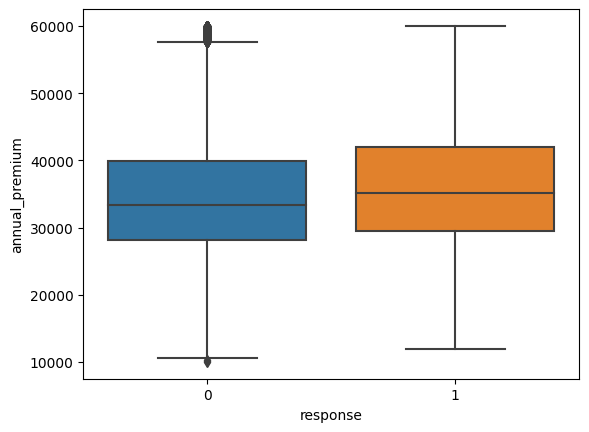

In [20]:
aux = df3[(df3['annual_premium'] > 10000) & (df3['annual_premium'] < 60000)]
sns.boxplot(x='response', y='annual_premium', data=aux)

<AxesSubplot: xlabel='annual_premium', ylabel='Count'>

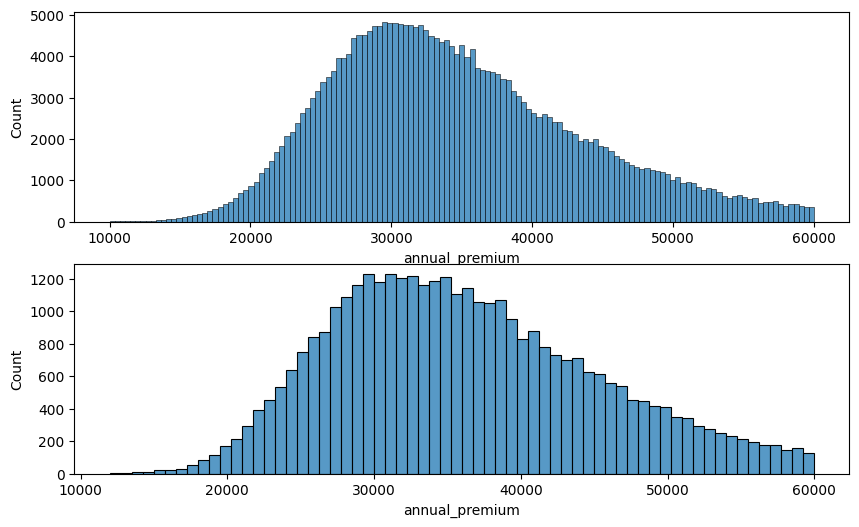

In [21]:
aux00 = aux.loc[aux['response'] == 0, 'annual_premium']
aux01 = aux.loc[aux['response'] == 1, 'annual_premium']

plt.figure(figsize=(10,6))

plt.subplot( 2, 1, 1 )
sns.histplot(aux00)

plt.subplot( 2, 1, 2 )
sns.histplot(aux01)

### 3.1.3 driving_license

<AxesSubplot: xlabel='response', ylabel='driving_license'>

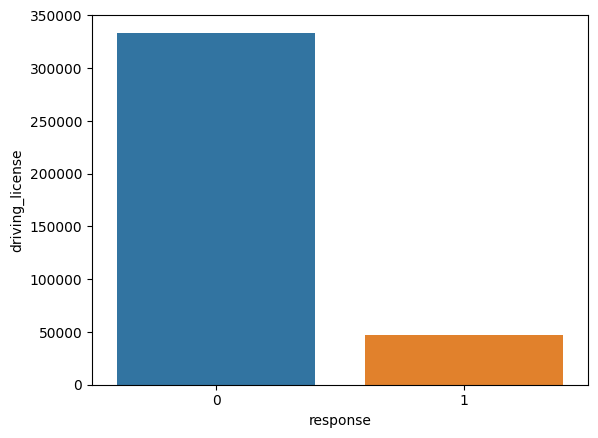

In [22]:
aux = df3[['driving_license', 'response']].groupby('response').sum().reset_index()
sns.barplot(x='response', y='driving_license', data=aux)

aux['driving_license_perc'] = (aux['driving_license'] / aux['driving_license'].sum()) * 100
auxaux = df3[['driving_license', 'response']].groupby('response').sum().reset_index()
sns.barplot(x='response', y='driving_license', data=aux)

In [23]:
aux['driving_license_perc'] = (aux['driving_license'] / aux['driving_license'].sum()) * 100
aux

,response,driving_license,driving_license_perc
0,0,333628,87.728276
1,1,46669,12.271724


### 3.1.4 region_code

<AxesSubplot: xlabel='region_code', ylabel='id'>

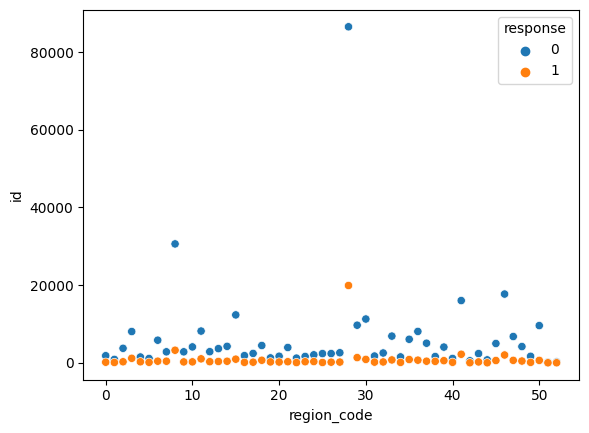

In [24]:
aux0 = df3[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
sns.scatterplot(x='region_code', y='id', hue='response', data=aux0)

### 3.1.5 previously_insured

In [25]:
pd.crosstab(df3['previously_insured'], df3['response']).apply(lambda x: x / x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


### 3.1.6 vehicle_age

In [26]:
df3[['vehicle_age', 'response']].value_counts(normalize=True).reset_index().sort_values('vehicle_age')

,vehicle_age,response,0
1,below_1_year,0,0.413488
4,below_1_year,1,0.018897
0,between_1_2_year,0,0.434285
2,between_1_2_year,1,0.091328
3,over_2_years,0,0.029663
5,over_2_years,1,0.012338


### 3.1.7 policy_sales_channel

<AxesSubplot: xlabel='response', ylabel='policy_sales_channel'>

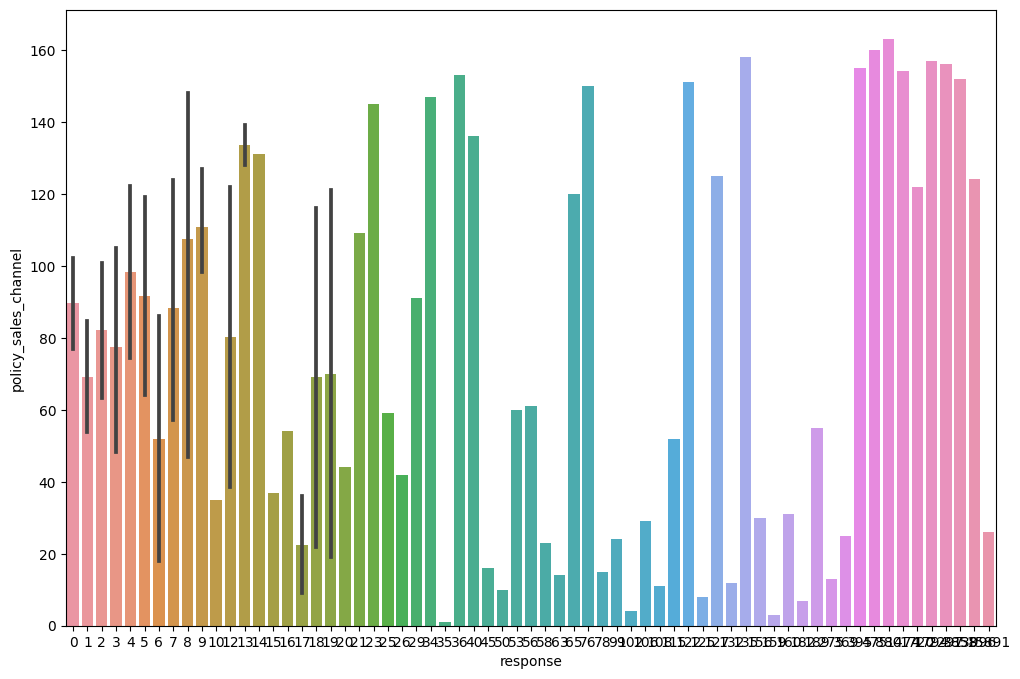

In [27]:
plt.figure(figsize=(12,8))
aux = df3[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot(x='response', y='policy_sales_channel', data=aux)

### 3.1.8 vintage

<AxesSubplot: xlabel='response', ylabel='vintage'>

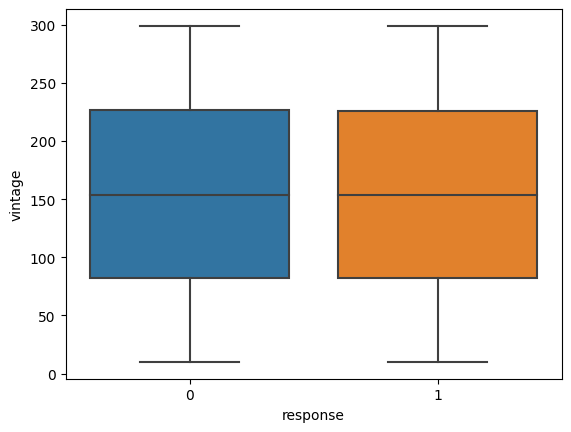

In [28]:
sns.boxplot(x='response', y='vintage', data=df3)

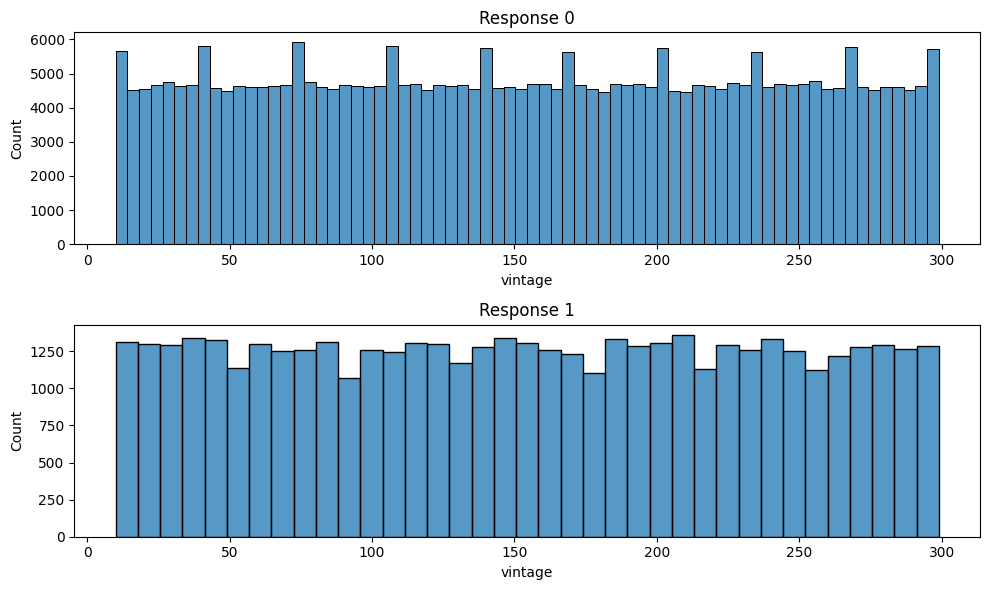

In [29]:
aux00 = df3.loc[df3['response'] == 0, 'vintage']
aux01 = df3.loc[df3['response'] == 1, 'vintage']

plt.figure(figsize=(10,6))
plt.subplot( 2, 1, 1 )
plt.title('Response 0')
sns.histplot(aux00)

plt.subplot( 2, 1, 2 )
plt.title('Response 1')
sns.histplot(aux01)

plt.tight_layout()

### 3.1.9 gender

In [30]:
pd.crosstab(df3['gender'], df3['response']).apply(lambda x: x / x.sum(), axis=1)

response,0,1
gender,,
Female,0.896098,0.103902
Male,0.861589,0.138411


# 4 DATA PREPARATION

In [91]:
df4 = df3.copy()

In [92]:
X = df4.drop('response', axis=1)
y = df4['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size=0.2)

df4 = pd.concat( [x_train, y_train], axis=1 )

## 4.1 Standardization

In [93]:
ss = pp.StandardScaler()

# annual_premium
df4['annual_premium'] = ss.fit_transform(df4[['annual_premium']].values)
pickle.dump(ss, open('../src/features/annual_premium_scaler.pkl', 'wb'))

## 4.2 Rescaling

In [94]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# age
df4['age'] = mms_age.fit_transform(df4[['age']].values)
pickle.dump(mms_age, open('../src/features/age_scaler.pkl', 'wb'))

# vintage
df4['vintage'] = mms_vintage.fit_transform(df4[['vintage']].values)
pickle.dump(mms_vintage, open('../src/features/vintage_scaler.pkl', 'wb'))

## 4.3 Encoder

In [95]:
# gender - One Hot Encoding / Target Encoding
target_encode_gender = df4.groupby('gender')['response'].mean()
df4.loc[:, 'gender'] = df4['gender'].map(target_encode_gender)
pickle.dump(target_encode_gender, open('../src/features/target_encode_gender_scaler.pkl', 'wb'))

# region_code - Frequency Encoding / Target Encoding / Weighted Target Encoding
target_encode_region_code = df4.groupby('region_code')['response'].mean()
df4.loc[:, 'region_code'] = df4['region_code'].map(target_encode_region_code)
pickle.dump(target_encode_region_code, open('../src/features/target_encode_region_code_scaler.pkl', 'wb'))

# vehicle_age - One Hot Encoding / Order Encoding / Frequency Encoding
df4 = pd.get_dummies(df4, prefix='vehicle_age', columns=['vehicle_age'])
# pickle.dump(ss, open('../src/features/annual_premium_scaler.pkl', 'wb'))

# policy_sales_channel - One Hot Encoding / Frequency Encoding / Target Encoding / Weighted Target Encoding
freq_policy_sales_channel = df4.groupby('policy_sales_channel').size() / len(df4)
df4.loc[:, 'policy_sales_channel'] = df4['policy_sales_channel'].map(freq_policy_sales_channel)
pickle.dump(freq_policy_sales_channel, open('../src/features/fe_policy_sales_channel_scaler.pkl', 'wb'))

/tmp/ipykernel_66630/740149533.py:3: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df4.loc[:, 'gender'] = df4['gender'].map(target_encode_gender)


## 4.4 Validation Preparation

In [36]:
# # gender
# x_validation.loc[:, 'gender'] = x_validation.loc[:, 'gender'].map(target_encode_gender)

# # age
# x_validation.loc[:, 'age'] = mms_age.transform( x_validation[['age']].values )

# # region_code
# x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map(target_encode_region_code)

# # vehicle_age
# x_validation = pd.get_dummies(x_validation, prefix='vehicle_age', columns=['vehicle_age'])

# # annual_premium
# x_validation.loc[:, 'annual_premium'] = ss.transform( x_validation[['annual_premium']].values )

# # policy_sales_channel
# x_validation.loc[:, 'policy_sales_channel'] = x_validation.loc[:, 'policy_sales_channel'].map(freq_policy_sales_channel)

# # vintage
# x_validation.loc[:, 'vintage'] = mms_vintage.transform( x_validation[['vintage']].values )

# # fillna
# x_validation = x_validation.fillna(0)

/tmp/ipykernel_66630/1085506009.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  x_validation.loc[:, 'gender'] = x_validation.loc[:, 'gender'].map(target_encode_gender)


# 5.0 FEATURE SELECTION

## 5.1 Features Importance

In [37]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=1)

# data preparation
x_train_n = df4.drop(['id', 'response'], axis=1)
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=1, random_state=0)

Feature Ranking: 
                        feature  importance
0                       vintage    0.272266
0                annual_premium    0.245011
0                           age    0.166275
0                   region_code    0.103123
0                vehicle_damage    0.068287
0          policy_sales_channel    0.060761
0            previously_insured    0.056134
0      vehicle_age_below_1_year    0.014667
0  vehicle_age_between_1_2_year    0.005843
0                        gender    0.004971
0      vehicle_age_over_2_years    0.002193
0               driving_license    0.000468


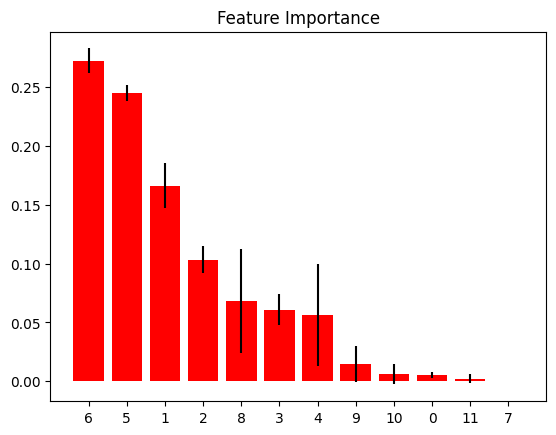

In [38]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# print the feature ranking
print('Feature Ranking: ')
df = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)
    
print(df.sort_values('importance', ascending=False))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title('Feature Importance')
plt.bar(range(x_train_n.shape[1]), 
        importances[indices], 
        color='r', 
        yerr=std[indices], 
        align='center')
plt.xticks(range(x_train_n.shape[1]), 
           indices) 
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 6.0 MACHINE LEARNING

In [39]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 
                 'previously_insured', 'policy_sales_channel']

In [40]:
x_train = df4[cols_selected]
x_val = x_validation[cols_selected]
y_val = y_validation.copy()

## 6.1 KNN

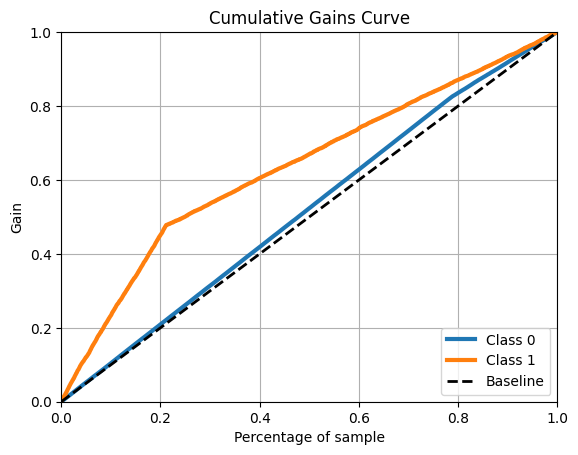

In [41]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=2)

# model_training
knn_model.fit(x_train, y_train)

# model prediction - Poder de Generalizacao
yhat_knn = knn_model.predict_proba(x_val)

# Acumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn);

## 6.2 Logistic Regression

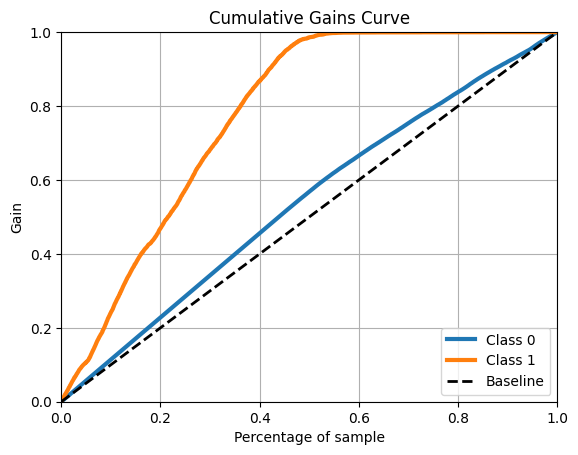

In [42]:
# model definition
lr_model = lm.LogisticRegression(random_state=42)

# model_training
lr_model.fit(x_train, y_train)

# model prediction - Poder de Generalizacao
yhat_lr = lr_model.predict_proba(x_val)

# Acumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr);

In [109]:
yhat_lr

array([[7.87043531e-01, 2.12956469e-01],
       [7.35265588e-01, 2.64734412e-01],
       [9.48817981e-01, 5.11820189e-02],
       ...,
       [7.67299943e-01, 2.32700057e-01],
       [9.99375196e-01, 6.24803999e-04],
       [7.71557831e-01, 2.28442169e-01]])

## 6.3 Extra Trees

In [43]:
# model definition
# et = en.ExtraTreesClassifier(n_estimators=10, n_jobs=-1, random_state=42)

# model fit
# et.fit(x_train, y_train)

# model predict
# yhat_et = et.predict_proba(x_val)

# 7.0 Model Performance

In [44]:
df7 = x_validation.copy()
df7['response'] = y_validation.copy()

In [45]:
# propensity score
df7['score'] = yhat_knn[:,1].tolist()

In [46]:
# sorted clients by propensity score
df7 = df7.sort_values('score', ascending=False)

In [112]:
yhat_lr[:,1]

array([0.21295647, 0.26473441, 0.05118202, ..., 0.23270006, 0.0006248 ,
       0.22844217])

In [47]:
def precision_at_k(data, k=2000):
    # reset index
    data = data.reset_index(drop=True)

    # order by ranking
    data['ranking'] = data.index + 1

    data['precision_at_k'] =  data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']

In [48]:
def recall_at_k(data, k=2000):
    # reset index
    data = data.reset_index(drop=True)

    # order by ranking
    data['ranking'] = data.index + 1

    data['recall_at_k'] =  data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']

In [49]:
precision_at_50 = precision_at_k(df7, 50)
print('Precision at K: {}'.format(precision_at_50))

recall_at_50 = recall_at_k(df7, 50)
print('Recall at K: {}'.format(recall_at_50))

Precision at K: 0.3333333333333333
Recall at K: 0.0018069727891156463


# 8.0 Deploy to Production

In [50]:
pickle.dump(lr_model, open('/home/vvilela/repos/health_insurance/models/model_linear_regression.pkl', 'wb'))

## 8.1 Health Insurance Class

In [51]:
import pickle
import pandas as pd
import numpy as np

class HealthInsurance():
    
    def __init__(self):
        self.home_path = '/home/vvilela/repos/health_insurance/'
        self.annual_premium_scaler =            pickle.load(open(self.home_path + 'src/features/annual_premium_scaler.pkl'))
        self.age_scaler =                       pickle.load(open(self.home_path + 'src/features/age_scaler.pkl'))
        self.vintage_scaler =                   pickle.load(open(self.home_path + 'src/features/vintage_scaler.pkl'))
        self.target_encode_gender_scaler =      pickle.load(open(self.home_path + 'src/features/target_encode_gender_scaler.pkl'))
        self.target_encode_region_code_scaler = pickle.load(open(self.home_path + 'src/features/target_encode_region_code_scaler.pkl'))
        self.fe_policy_sales_channel_scaler =   pickle.load(open(self.home_path + 'src/features/fe_policy_sales_channel_scaler.pkl'))
        
    def data_engineering(data):
        # vehicle_damage
        data['vehicle_damage'] = data['vehicle_damage'].apply( lambda x: 1 if x=='Yes' else 0)
        
        # vehicle_age
        data['vehicle_age'] = data['vehicle_age'].apply( lambda x: 'over_2_years' if x=='> 2 Years' else
                                                         'between_1_2_year' if x=='1-2 Year' else 'below_1_year')
        return data
    

    def data_preparation(data):

        # annual_premium
        data['annual_premium'] = self.annual_premium_scaler.transform(data[['annual_premium']].values)
        
        # age
        data['age'] = self.age_scaler.transform(data[['age']].values)

        # vintage
        data['vintage'] = self.vintage_scaler.transform(data[['vintage']].values)

        # gender
        data.loc[:, 'gender'] = data['gender'].map(self.target_encode_gender_scaler)

        # region_code
        data.loc[:, 'region_code'] = data['region_code'].map(self.target_encode_region_code_scaler)

        # policy_sales_channel
        data.loc[:, 'policy_sales_channel'] = data['policy_sales_channel'].map(self.fe_policy_sales_channel_scaler)

        cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 
                         'previously_insured', 'policy_sales_channel']
        
        return data[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        # model prediction
        pred = model.predict_proba(test_data)
        
        # join prediction into original data
        original_data['prediction'] = pred
        
        return original_data.to_json(orient='records', date_format='iso')

## 8.2 API Handler

In [52]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from health_insurance import HealthInsurance

# loading model
path = '/home/vvilela/repos/health_insurance/models/'
model = pickle.load(open( path + 'model_linear_regression.pkl', 'rb'))

# initialize API
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json: # data
        if isinstance(test_json, dict): # unique example
            test_raw = pd.DataFrame(test_json, index=[0])
            
        else: # multiple example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys() )
    
        # instanciate health insurance class
        pipeline = HealthInsurance()

        df1 = pipeline.data_cleaning(test_raw)

        df2 = pipeline.data_engineering(df1)

        df3 = pipeline.data_preparation(df2)

        df_response = pipeline.get_prediction(model, test_raw, df3)

        return df_response
    
    else:
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run('0.0.0.0', debug=True)

ModuleNotFoundError: No module named 'health_insurance'

## 8.3 API Tester

In [53]:
import requests
import json

In [97]:
df_test = x_validation
df_test['response'] = y_validation

In [119]:
df_test = df_test.sample(10)
df_test.to_csv('sample_dataset.csv', index=False)

In [127]:
data = json.dumps(df_test.to_dict(orient='records'))
data

'[{"id": 250747, "gender": "Male", "age": 72, "region_code": 41.0, "policy_sales_channel": 26.0, "previously_insured": 1, "annual_premium": 41362.0, "vintage": 74, "driving_license": 1, "vehicle_age": "between_1_2_year", "vehicle_damage": 0, "response": 0}, {"id": 348736, "gender": "Female", "age": 24, "region_code": 15.0, "policy_sales_channel": 152.0, "previously_insured": 1, "annual_premium": 2630.0, "vintage": 184, "driving_license": 1, "vehicle_age": "below_1_year", "vehicle_damage": 0, "response": 0}, {"id": 361707, "gender": "Female", "age": 22, "region_code": 15.0, "policy_sales_channel": 152.0, "previously_insured": 1, "annual_premium": 2630.0, "vintage": 101, "driving_license": 1, "vehicle_age": "below_1_year", "vehicle_damage": 0, "response": 0}, {"id": 343151, "gender": "Female", "age": 58, "region_code": 28.0, "policy_sales_channel": 122.0, "previously_insured": 0, "annual_premium": 30031.0, "vintage": 20, "driving_license": 1, "vehicle_age": "over_2_years", "vehicle_damag

In [151]:
# API Call
url = 'http://0.0.0.0:8000/predict'
header = {'Content-type': 'application/json'}

In [153]:
r = requests.post(url, headers=header, data=data )
print(f'Status Code {r.status_code}')

Status Code 200


In [147]:
type(r.json())

list

In [148]:
a = pd.DataFrame.from_dict(r.json())
a

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,driving_license,vehicle_age,vehicle_damage,response,prediction
0,250747,0.138360,0.800000,0.122853,0.209179,1,0.624502,0.221453,1,between_1_2_year,0,0,0.000640
1,348736,0.103867,0.061538,0.072404,0.353770,1,-1.614909,0.602076,1,below_1_year,0,0,0.000499
2,361707,0.103867,0.030769,0.072404,0.353770,1,-1.614909,0.314879,1,below_1_year,0,0,0.000500
3,343151,0.103867,0.584615,0.186546,0.026174,0,-0.030635,0.034602,1,over_2_years,0,0,0.052524
4,48227,0.103867,0.353846,0.094319,0.003792,0,-0.068968,0.432526,1,between_1_2_year,0,0,0.037128
5,372643,0.138360,0.030769,0.114565,0.353770,1,-1.614909,0.605536,1,below_1_year,0,0,0.000608
6,356604,0.138360,0.246154,0.079448,0.209179,0,0.224516,0.996540,1,between_1_2_year,0,1,0.030274
7,238098,0.138360,0.723077,0.114565,0.209179,0,-1.614909,0.626298,1,between_1_2_year,0,0,0.032038
8,142366,0.103867,0.615385,0.186546,0.209179,0,1.555489,0.716263,1,between_1_2_year,0,0,0.046346
9,183314,0.103867,0.153846,0.079448,0.353770,1,0.110557,0.885813,1,below_1_year,0,0,0.000519
